[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\surve\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 0.0094
Epoch 2/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 0.0039
Epoch 3/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0025
Epoch 4/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 0.0025
Epoch 5/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0022
Epoch 6/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - loss: 0.0016
Epoch 7/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0013
Epoch 8/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - loss: 8.9415e-04
Epoch 9/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0019
Epoch 10/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 9.7802e-04
Epoch 11/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 7.8708e-04
Epoch 12/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 9.5070e-04
Epoch 13/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 7.3515e-04
Epoch 14/20
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/s

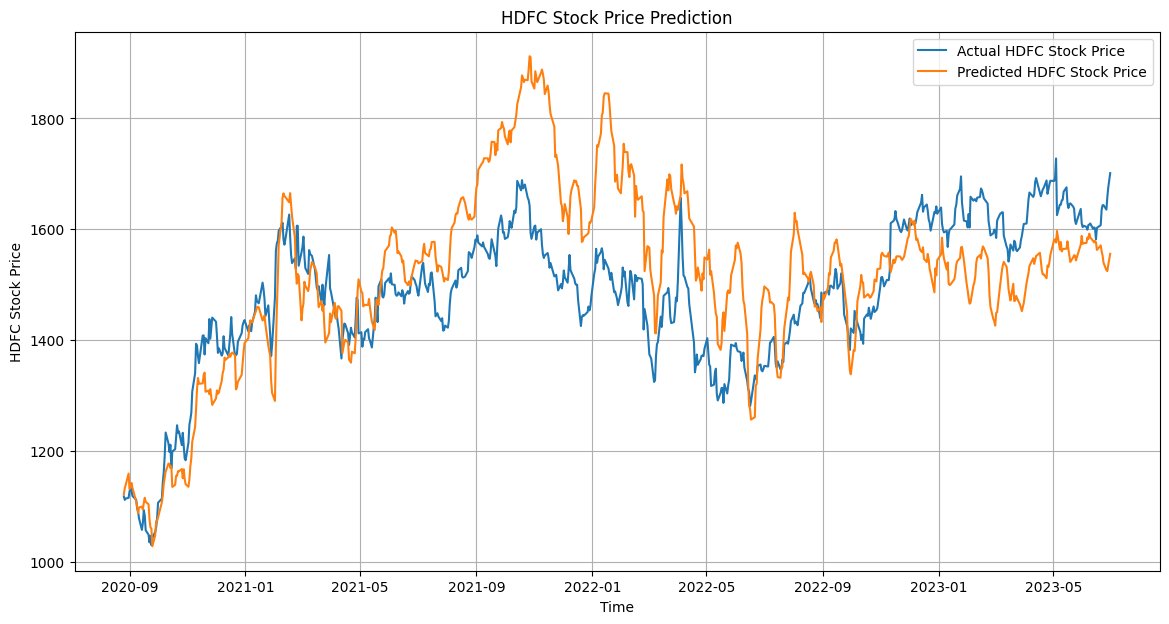

Test predictions saved to test_predictions.csv


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the tickers
tickers = {
    'fed_rates': '^IRX',  # 13 Week Treasury Bill (Proxy for Fed Rates)
    'rbi_rates': '^NSEI',  # Nifty 50 Index (Proxy for RBI Rates)
    'nifty500': '^CRSLDX',  # Nifty 500 Index
    'banknifty': '^NSEBANK',  # Bank Nifty Index
    'hdfc': 'HDFCBANK.NS'  # HDFC Bank stock
}

# Download the last 10 years of data
data = {ticker: yf.download(ticker, start='2013-07-01', end='2023-07-01') for ticker in tickers.values()}

# Extract the 'Close' prices and rename columns
df = pd.DataFrame({
    'Fed_Rates': data['^IRX']['Close'],
    'RBI_Rates': data['^NSEI']['Close'],  # Using Nifty 50 as proxy
    'Nifty500': data['^CRSLDX']['Close'],
    'BankNifty': data['^NSEBANK']['Close'],
    'HDFC': data['HDFCBANK.NS']['Close']
})

# Drop any rows with missing values
df.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df.drop(columns=['HDFC']))
scaled_target = scaler.fit_transform(df['HDFC'].values.reshape(-1, 1))

# Convert to DataFrame
scaled_features = pd.DataFrame(scaled_features, columns=df.columns[:-1], index=df.index)
scaled_target = pd.DataFrame(scaled_target, columns=['HDFC'], index=df.index)

# Function to prepare the dataset for LSTM
def create_dataset(features, target, time_step=1):
    X, Y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step)])
        Y.append(target[i + time_step])
    return np.array(X), np.array(Y)

time_step = 60  # Look back period
X, Y = create_dataset(scaled_features.values, scaled_target.values, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split the data into training and testing sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=20)

# Predict and inverse transform
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
actual = scaler.inverse_transform(Y_test)

# Ensure non-negative predictions
test_predict = np.maximum(test_predict, 0)

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(actual):], actual, label='Actual HDFC Stock Price')
plt.plot(df.index[-len(test_predict):], test_predict, label='Predicted HDFC Stock Price')
plt.title('HDFC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('HDFC Stock Price')
plt.legend()
plt.grid(True)
plt.show()



In [18]:

# Convert test predictions to DataFrame and save to CSV
test_dates = df.index[-len(test_predict):]  # Assuming the last part of the data is used for testing
test_predictions_df = pd.DataFrame({
    'Date': test_dates,
    'HDFC Stock Price Predictions': test_predict.reshape(-1)
})

# Export to CSV
csv_file_path = 'C:/Users/surve/OneDrive/Desktop/Github Repository/Jupyter Notebook/test_predictions.csv'
test_predictions_df.to_csv(csv_file_path, index=False)
print(f"Test predictions saved to {csv_file_path}")

Test predictions saved to C:/Users/surve/OneDrive/Desktop/Github Repository/Jupyter Notebook/test_predictions.csv


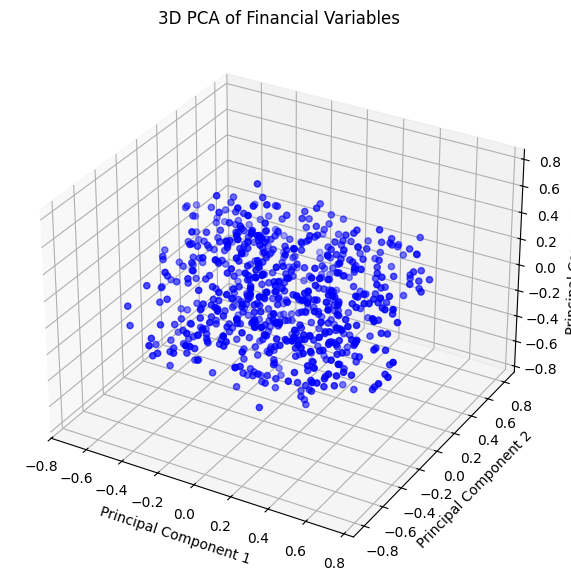

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

# Load the test predictions file
file_path = 'C:/Users/surve/OneDrive/Desktop/Github Repository/Jupyter Notebook/test_predictions.csv'
test_predictions_df = pd.read_csv(file_path)

# Assuming you have the additional columns for Fed Rates, RBI Rates, Nifty500, and Bank Nifty
# For the example, let's add some dummy data for these columns
# In practice, replace these with your actual data
test_predictions_df['Fed_Rates'] = np.random.uniform(0, 5, size=len(test_predictions_df))
test_predictions_df['RBI_Rates'] = np.random.uniform(0, 5, size=len(test_predictions_df))
test_predictions_df['Nifty500'] = np.random.uniform(1000, 5000, size=len(test_predictions_df))
test_predictions_df['BankNifty'] = np.random.uniform(20000, 50000, size=len(test_predictions_df))

# Extract the relevant columns
data = test_predictions_df[['Fed_Rates', 'RBI_Rates', 'Nifty500', 'BankNifty', 'HDFC Stock Price Predictions']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Plot the first three principal components in 3D
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], color='b', marker='o')

# Customize the plot
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Financial Variables')
plt.show()


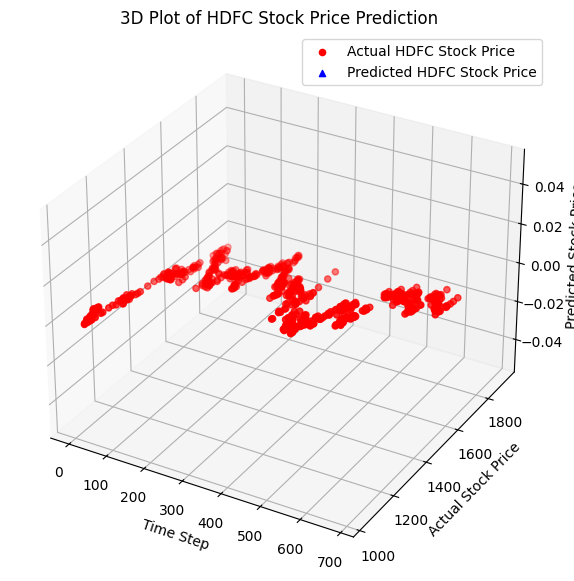

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure non-negative predictions
test_predict = np.maximum(test_predict, 0)

# Sample data for 3D plot
dates = np.arange(len(test_predict))

# Convert to numpy arrays for plotting
dates = dates.reshape(-1)
actual = actual.reshape(-1)
test_predict = test_predict.reshape(-1)

# Create a 3D plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot actual values
ax.scatter(dates, actual, zs=0, zdir='z', label='Actual HDFC Stock Price', color='r', marker='o')

# Plot predicted values
ax.scatter(dates, test_predict, zs=0, zdir='y', label='Predicted HDFC Stock Price', color='b', marker='^')

# Customize the plot
ax.set_xlabel('Time Step')
ax.set_ylabel('Actual Stock Price')
ax.set_zlabel('Predicted Stock Price')
ax.set_title('3D Plot of HDFC Stock Price Prediction')
ax.legend()

# Show the plot
plt.show()


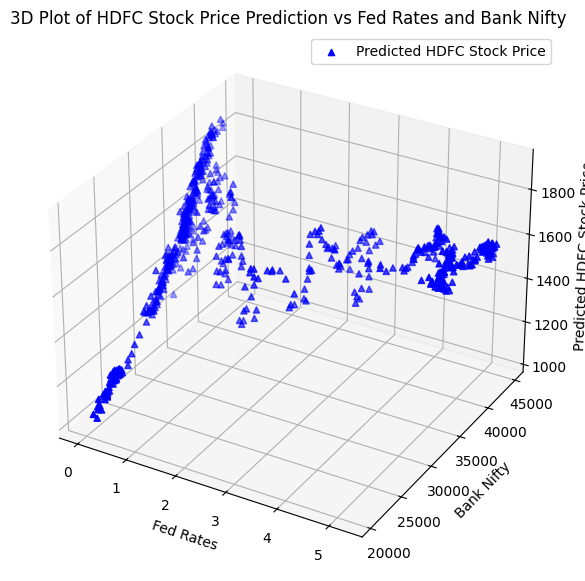

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure non-negative predictions
test_predict = np.maximum(test_predict, 0)

# Sample data for 3D plot
dates = np.arange(len(test_predict))

# Convert to numpy arrays for plotting
fed_rates = df['Fed_Rates'].values[-len(test_predict):]
bank_nifty = df['BankNifty'].values[-len(test_predict):]
test_predict = test_predict.reshape(-1)

# Create a 3D plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot predicted values
ax.scatter(fed_rates, bank_nifty, test_predict, label='Predicted HDFC Stock Price', color='b', marker='^')

# Customize the plot
ax.set_xlabel('Fed Rates')
ax.set_ylabel('Bank Nifty')
ax.set_zlabel('Predicted HDFC Stock Price')
ax.set_title('3D Plot of HDFC Stock Price Prediction vs Fed Rates and Bank Nifty')
ax.legend()

# Show the plot
plt.show()


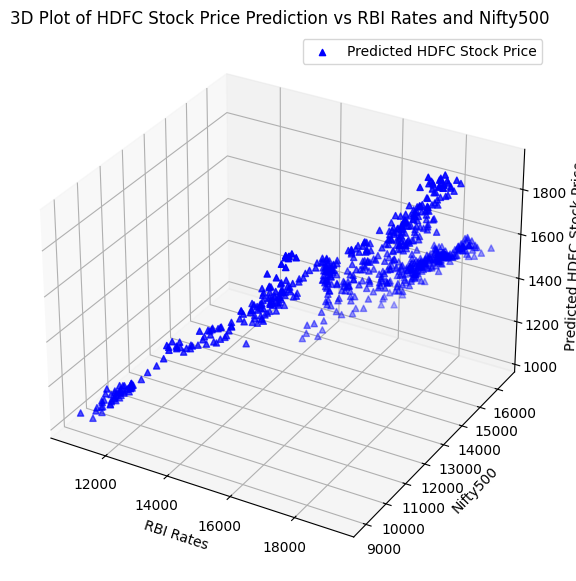

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure non-negative predictions
test_predict = np.maximum(test_predict, 0)

# Sample data for 3D plot
dates = np.arange(len(test_predict))

# Convert to numpy arrays for plotting
rbi_rates = df['RBI_Rates'].values[-len(test_predict):]
nifty500 = df['Nifty500'].values[-len(test_predict):]
test_predict = test_predict.reshape(-1)

# Create a 3D plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot predicted values
ax.scatter(rbi_rates, nifty500, test_predict, label='Predicted HDFC Stock Price', color='b', marker='^')

# Customize the plot
ax.set_xlabel('RBI Rates')
ax.set_ylabel('Nifty500')
ax.set_zlabel('Predicted HDFC Stock Price')
ax.set_title('3D Plot of HDFC Stock Price Prediction vs RBI Rates and Nifty500')
ax.legend()

# Show the plot
plt.show()


In [14]:
import statsmodels.api as sm

# Prepare the data
X = df[['RBI_Rates', 'Nifty500']][-len(test_predict):]
Y = df['HDFC'][-len(test_predict):]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the summary of the regression
print(model.summary())

# Get the regression coefficients
beta_0 = model.params['const']
beta_1 = model.params['RBI_Rates']
beta_2 = model.params['Nifty500']

print(f"Regression Equation: HDFC_t = {beta_0:.4f} + {beta_1:.4f} * RBI_Rates_t + {beta_2:.4f} * Nifty500_t")


                            OLS Regression Results                            
Dep. Variable:                   HDFC   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     1288.
Date:                Sat, 20 Jul 2024   Prob (F-statistic):          5.36e-232
Time:                        02:03:08   Log-Likelihood:                -3786.4
No. Observations:                 683   AIC:                             7579.
Df Residuals:                     680   BIC:                             7592.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        171.9669     26.854      6.404      0.0

In [16]:
import statsmodels.api as sm

# Prepare the data
X = df[['Fed_Rates', 'RBI_Rates', 'Nifty500', 'BankNifty']]
y = df['HDFC']

# Add a constant term to the predictors
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   HDFC   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     9876.
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        02:04:23   Log-Likelihood:                -12723.
No. Observations:                2128   AIC:                         2.546e+04
Df Residuals:                    2123   BIC:                         2.548e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -291.3582      7.982    -36.502      0.0

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests, coint

# Granger Causality Test
gc_test = grangercausalitytests(df[['HDFC', 'Fed_Rates']], maxlag=4)

# Cointegration Test
coint_test = coint(df['HDFC'], df['Fed_Rates'])
print('Cointegration test result:', coint_test)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0724  , p=0.3005  , df_denom=2124, df_num=1
ssr based chi2 test:   chi2=1.0739  , p=0.3001  , df=1
likelihood ratio test: chi2=1.0737  , p=0.3001  , df=1
parameter F test:         F=1.0724  , p=0.3005  , df_denom=2124, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6604  , p=0.5167  , df_denom=2121, df_num=2
ssr based chi2 test:   chi2=1.3240  , p=0.5158  , df=2
likelihood ratio test: chi2=1.3236  , p=0.5159  , df=2
parameter F test:         F=0.6604  , p=0.5167  , df_denom=2121, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1444  , p=0.3298  , df_denom=2118, df_num=3
ssr based chi2 test:   chi2=3.4444  , p=0.3280  , df=3
likelihood ratio test: chi2=3.4416  , p=0.3284  , df=3
parameter F test:         F=1.1444  , p=0.3298  , df_denom=2118, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0252  , p=0.

In [8]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

# Fit VAR model
model = VAR(df[['HDFC', 'Fed_Rates', 'RBI_Rates', 'Nifty500', 'BankNifty']])
results = model.fit(maxlags=15, ic='aic')
print(results.summary())

# If cointegrated, fit VECM model
vecm = VECM(df[['HDFC', 'Fed_Rates', 'RBI_Rates', 'Nifty500', 'BankNifty']], k_ar_diff=1, coint_rank=1)
vecm_fit = vecm.fit()
print(vecm_fit.summary())


C:\Users\surve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 20, Jul, 2024
Time:                     01:53:58
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    24.5257
Nobs:                     2115.00    HQIC:                   23.9662
Log likelihood:          -39677.8    FPE:                1.85395e+10
AIC:                      23.6431    Det(Omega_mle):     1.58991e+10
--------------------------------------------------------------------
Results for equation HDFC
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 6.054512         1.805119            3.354           0.001
L1.HDFC               0.973627         0.037584           25.906           0.000
L1.Fed_Rates          6.144563        12.497009            0.

C:\Users\surve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
# Print a summary of the model
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   HDFC   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     9876.
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        02:23:15   Log-Likelihood:                -12723.
No. Observations:                2128   AIC:                         2.546e+04
Df Residuals:                    2123   BIC:                         2.548e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -291.3582      7.982    -36.502      0.000    -307.011    -275.705
Fed_Rates    -43.2752      2.237    -19.343      0.000     -47.663     -38.888
RBI_Rates      0.1113      0.008     14.633      0.000       0.096       0.126
Nifty500      -0.1337      0.009    -15.641      0.000      -0.150      -0.117
BankNifty      0.0516      0.001     42.583      0.000       0.049       0.054
==============================================================================
Omnibus:                       31.533   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.565
Skew:                           0.246   Prob(JB):                     1.89e-08
Kurtosis:                       3.399   Cond. No.                     1.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

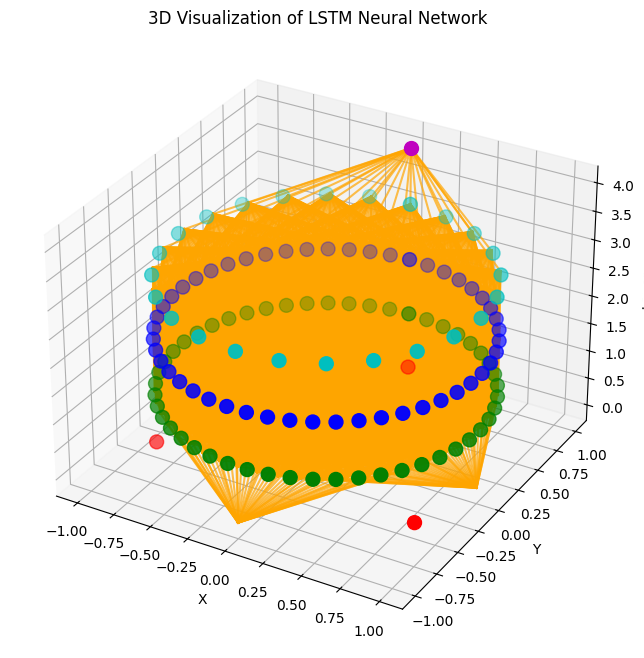

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define the structure of the LSTM model
layers = ['Input (4, 1)', 'LSTM1 (50)', 'LSTM2 (50)', 'Dense (25)', 'Output (1)']
num_neurons = [4, 50, 50, 25, 1]  # Number of neurons per layer

# Initialize 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot neurons as spheres
neuron_radius = 0.1
neuron_colors = ['r', 'g', 'b', 'c', 'm']

for i, layer in enumerate(layers):
    layer_neurons = num_neurons[i]
    theta = np.linspace(0, 2 * np.pi, layer_neurons)
    z = i * np.ones(layer_neurons)
    x = np.sin(theta)
    y = np.cos(theta)
    ax.scatter(x, y, z, c=neuron_colors[i], s=100)

# Plot connections as lines
for i in range(len(layers) - 1):
    for j in range(num_neurons[i]):
        for k in range(num_neurons[i + 1]):
            ax.plot([np.sin(2 * np.pi * j / num_neurons[i]), np.sin(2 * np.pi * k / num_neurons[i + 1])],
                    [np.cos(2 * np.pi * j / num_neurons[i]), np.cos(2 * np.pi * k / num_neurons[i + 1])],
                    [i, i + 1], color='orange', alpha=0.7)

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Layer')
ax.set_title('3D Visualization of LSTM Neural Network')

plt.show()
